## Import Modules

In [1]:
# Core
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


# Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import wordcloud
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk.collocations as nc
import spacy
nlp = spacy.load('en_core_web_sm')
# we should remove stopwords, including google and tesla
stops = stopwords.words('english') + ['google', 'tesla']
en_stopwords = set(stops)
from textblob import TextBlob
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Time Series
import seaborn as sns
sns.set(style="ticks", color_codes=True)

# Geo
import folium
import os


## Import Datasets 
#### (Google & Tesla reviews web-scraped from Indeed)

In [2]:
# Code Source 
# https://stackoverflow.com/questions/16888888/how-to-read-a-xlsx-file-
# using-the-pandas-library-in-ipython

df_google = pd.read_excel('google_reviews.xlsx', sheet_name="sheet1")
df_tesla = pd.read_excel('tesla_reviews.xlsx', sheet_name="sheet1")

# Use for geo
# https://developers.google.com/public-data/docs/canonical/states_csv
df_state_geo = pd.read_csv('states_geo.csv')

## EDA & Data Cleaning

In [3]:
# Code Source
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial
df_google.info()
df_tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 6 columns):
title       1326 non-null object
reviewer    1329 non-null object
location    1329 non-null object
date        1329 non-null object
rating      1329 non-null float64
reviews     1329 non-null object
dtypes: float64(1), object(5)
memory usage: 62.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 6 columns):
title       1233 non-null object
reviewer    1235 non-null object
location    1235 non-null object
date        1235 non-null object
rating      1235 non-null float64
reviews     1235 non-null object
dtypes: float64(1), object(5)
memory usage: 58.0+ KB


####  Convert data types

In [4]:
# Code Source
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Date to date data type
df_google.date = pd.to_datetime(df_google.date)
df_tesla.date = pd.to_datetime(df_tesla.date)

# Rating to integer
df_google.rating = df_google.rating.astype(np.int64)
df_tesla.rating = df_tesla.rating.astype(np.int64)

In [5]:
# Take a look at the google dataframe
df_google.head(2)

,title,reviewer,location,date,rating,reviews
0,Awesome,Camp Counselor (Former Employee) –,"Northborough, MA",2018-01-17,5,Awesome stuff at google if I had to rate it fr...
1,Google is great Bon Apeptit isn’t so great!,Micro kitchen attendant (Former Employee) –,"Mountain View, CA",2018-08-24,5,Google is a great company and the googler were...


In [6]:
# Take a look at the tesla dataframe
df_tesla.head(2)

,title,reviewer,location,date,rating,reviews
0,Stressful,PV Design Engineer II (Current Employee) –,"Westborough, MA",2018-06-14,3,Very tight Schedule.Get to learn a little.Aver...
1,Looks good on the resume,Service Advisor (Former Employee) –,"Burbank, CA",2019-01-16,3,Tesla asks if you're okay with overtime but yo...



#### Create employee type (former or current employee) from reviewer variable

In [7]:
# Strip out former/current employee and make it's own variable
# Code Source: 
# https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/

# split reviewer variable on '(' 
new_google = df_google["reviewer"].str.split("(", n = 1, expand = True) 
new_tesla = df_tesla["reviewer"].str.split("(", n = 1, expand = True) 

# make job title column from the left part of the split 
df_google["job_title"]= new_google[0] 
df_tesla["job_title"]= new_tesla[0] 
  
# make emp type column from the right part of the split
df_google["emp_status"]= new_google[1] 
df_tesla["emp_status"]= new_tesla[1] 

# Drop reviewer column 
df_google.drop('reviewer', inplace=True, axis=1)
df_tesla.drop('reviewer', inplace=True, axis=1) 

In [8]:
# Now have 7 variables, created employee type & job title, dropped reviewer
df_google.shape

(1329, 7)

In [9]:
df_tesla.shape

(1235, 7)

In [10]:
# Code Source
# https://stackoverflow.com/questions/22391433/count-the-frequency
# -that-a-value-occurs-in-a-dataframe-column

# Get a count of each employee status category
df_google['emp_status'].value_counts()

Former Employee) –                                                     826
Current Employee) –                                                    454
Contract) (Former Employee) –                                           12
Contractor) (Former Employee) –                                          6
contract) (Current Employee) –                                           2
Contract) (Current Employee) –                                           2
LCS), Big Box Vertical (Former Employee) –                               1
Contractor) (Current Employee) –                                         1
Business Applications) (Current Employee) –                              1
Full-time) (Former Employee) –                                           1
temp. contractor) (Former Employee) –                                    1
Consulting) (Former Employee) –                                          1
Fixed-Term) (Former Employee) –                                          1
Google Shopping Express) 

In [11]:
df_tesla['emp_status'].value_counts()

Former Employee) –                                     728
Current Employee) –                                    490
Temp) (Former Employee) –                                2
SEASONAL) (Former Employee) –                            1
 Lead-Davie) (Former Employee) –                         1
Automation) (Former Employee) –                          1
Paint) (Former Employee) –                               1
Full-time) (Current Employee) –                          1
Production Control /Model 3) (Current Employee) –        1
Swing Shift) (Former Employee) –                         1
CDL) (Current Employee) –                                1
contract) (Former Employee) –                            1
PLM) Program Manager (Former Employee) –                 1
Mechanical Joining) (Current Employee) –                 1
Powertrain Conveyance) (Current Employee) –              1
Production Associate) -Via (Current Employee) –          1
Contract) (Former Employee) –                           

In [115]:
# Code Source
# https://stackoverflow.com/questions/18196203/
# how-to-conditionally-update-dataframe-column-in-pandas

# Pretty much an if statement - if emp_status contains 'Current', make it 'current', else make it 'former'
df_google['emp_status'] = np.where(df_google['emp_status'].str.contains('Current'), 'current', 'former')

df_tesla['emp_status'] = np.where(df_tesla['emp_status'].str.contains('Current'), 'current', 'former')

In [13]:
# Will make clean categories - current/former
df_google['emp_status'].value_counts()

former     863
current    466
Name: emp_status, dtype: int64

In [14]:
df_tesla['emp_status'].value_counts()

former     738
current    497
Name: emp_status, dtype: int64

#### Create state from location variable

In [15]:
# Strip out state and make it's own variable

# split location variable on ',' 
new_google = df_google["location"].str.split(",", n = 1, expand = True) 
new_tesla = df_tesla["location"].str.split(",", n = 1, expand = True) 

# make state column from the right part of the split 
df_google["state"]= new_google[1] 
df_tesla["state"]= new_tesla[1] 

# Drop location column 
df_google.drop('location', inplace=True, axis=1)
df_tesla.drop('location', inplace=True, axis=1) 

In [16]:
# Code Source
# https://stackoverflow.com/questions/36505847/substring-of-an-entire-column-in-pandas-dataframe

# Take the first two characters
df_google.state = df_google.state.str.slice(1, 3)
df_tesla.state = df_tesla.state.str.slice(1, 3)

In [17]:
# Code Source
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.upper.html

# Upper case the state code extracted
df_google.state = df_google.state.str.upper()
df_tesla.state = df_tesla.state.str.upper()

In [18]:
# Get a count of each employee status category
df_google['state'].value_counts()

CA    629
NY    117
WA     58
TX     48
GA     41
MI     36
IL     30
MA     26
PA     21
FL     19
AZ     18
MO     16
NC     16
CO     12
DC     12
IA     11
OR      9
UT      9
SC      6
NM      4
NV      4
NJ      4
AL      3
TN      3
MD      3
ID      3
KS      3
WI      3
OK      2
VA      2
        2
OH      2
IN      2
E       1
MS      1
CT      1
A       1
ES      1
DA      1
AS      1
AR      1
D       1
VT      1
CE      1
A.      1
NH      1
PR      1
Name: state, dtype: int64

In [19]:
# Code Source
# https://thispointer.com/python-how-to-check-if-an-item-exists-in-list-search-by-value-or-condition/

def state_lookup(df):
    # If valid state code, keep it, else assign 'ERR'
    for i in range(0,len(df)):
        if df.iloc[i] in df_state_geo['state'].values.tolist():
            df[i] = df[i]
        else:
            df[i] = 'ERR'
        

In [20]:
state_lookup(df_google.state)

/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [21]:
state_lookup(df_tesla.state)

/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/christiandavies/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [22]:
# Get a count of reviews in each state
df_google['state'].value_counts()

CA     629
ERR    151
NY     117
WA      58
TX      48
GA      41
MI      36
IL      30
MA      26
PA      21
FL      19
AZ      18
NC      16
MO      16
CO      12
DC      12
IA      11
OR       9
UT       9
SC       6
NV       4
NM       4
NJ       4
KS       3
TN       3
ID       3
AL       3
WI       3
MD       3
IN       2
VA       2
OK       2
OH       2
MS       1
CT       1
AR       1
VT       1
NH       1
PR       1
Name: state, dtype: int64

In [23]:
# Get a count of reviews in each state
df_tesla['state'].value_counts()

CA     784
NV     175
ERR     81
TX      32
NY      20
UT      18
CO      14
FL      12
MD      10
MA       9
NJ       8
PA       8
OH       7
NC       6
DE       5
AZ       5
VA       4
WA       4
CT       4
GA       3
VT       3
HI       3
OR       3
IL       2
MI       2
MN       2
NM       2
LA       1
OK       1
ID       1
AK       1
NE       1
KS       1
IN       1
ND       1
TN       1
Name: state, dtype: int64

In [24]:
# Code source
# https://medium.com/importexcel/common-excel-task-
# in-python-vlookup-with-pandas-merge-c99d4e108988

# Merge longitude/latitude to dataframe, will use later for geo
df_google = pd.merge(df_google,df_state_geo, how='left', on='state')
df_tesla = pd.merge(df_tesla, df_state_geo, how='left', on='state')


In [25]:
# Assign company variable
df_google['Company'] = 'google'
df_tesla['Company'] = 'tesla'

In [26]:
# Code Source
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

# Union google and tesla datasets for bar chart
frames = [df_google, df_tesla]

df_comp = pd.concat(frames)

In [27]:
# Change data type for categorical variables
df_comp['emp_status'] = df_comp['emp_status'].astype('category')
df_comp['Company'] = df_comp['Company'].astype('category')
df_comp['state'] = df_comp['state'].astype('category')

#### Explore newly created employee status variable

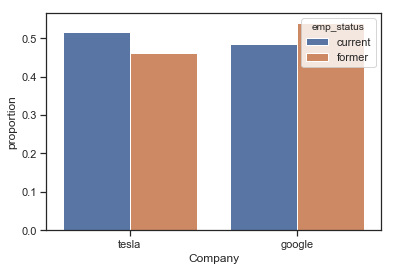

In [28]:
# https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot

x, y, hue = "Company", "proportion", "emp_status"
# hue_order = ["Male", "Female"]

(df_comp[x]
 .groupby(df_comp[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue));

#### Explore rating variable

In [29]:
# Look at Rating Summary for Google
df_google['rating'].describe()

count    1329.000000
mean        4.221971
std         0.999065
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

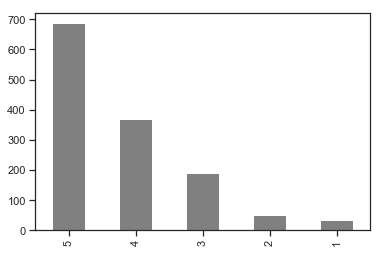

In [30]:
# Rating Frequency Bar Plot Google
df_google['rating'].value_counts().plot.bar(color='Gray');

In [31]:
# Look at Rating Summary for Tesla
df_tesla['rating'].describe()

count    1235.000000
mean        3.587854
std         1.277285
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

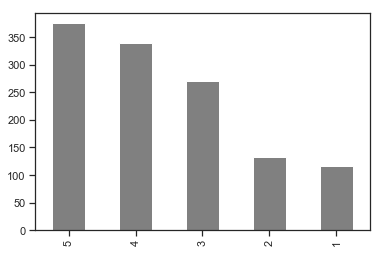

In [32]:
# Rating Frequency Bar Plot Google
df_tesla['rating'].value_counts().plot.bar(color='Gray');

#### TF-IDF


In [33]:
# Combine title and reviews to clean for each review
google_review_text = df_google["title"] + ' ' + df_google["reviews"]
tesla_review_text = df_tesla["title"] + ' ' + df_tesla["reviews"]

In [34]:
google_review_text[1]

'Google is great Bon Apeptit isn’t so great! Google is a great company and the googler were awesome, knowledgeable and open to teaching. It was the company I was contacted with Bon Apeptit that was terrible the management was u professional much like being on highschool. Not much room for advancement unless you were related to someone that worked there. I worked there for a year only revived a 2% increase in my raise so after a year in a half I was at 15.30. I felt like I was treated poorly by management there. As well as my health and safety while working was put at risk'

In [35]:
tesla_review_text[1]

"Looks good on the resume Tesla asks if you're okay with overtime but you don't realize you're giving up all your personal time. As a service advisor, you start your day writing tickets and interacting with customers. Throughout the day, you need to keep up with updating customers three times a day while stuck on the drive. Management sets expectations that aren't feasible and focus on the customer service index that you don't always have control over (the customers not filling out the survey or deleting them). It was difficult to balance the work load and a personal life with the amount of time it takes to keep customers in the loop."

In [36]:
# Parts of code from Week 3 and Week 6 Solution
# Regis Text Analytics Class - Dr. Nathan George

# Function to clean text
def preprocess_text(text_docs):
   
    # remove punctuation
    table = str.maketrans({key: None for key in string.punctuation})
    docs = [str(d).translate(table) for d in text_docs]
    # replace newlines with spaces
    docs = [re.sub('[\r\n]+', ' ', d) for d in docs]
    # replace website links with space -- want to do this before digits
    docs = [re.sub('https[\w]*', ' ', d) for d in docs]
    # replace digits with space
    docs = [re.sub('\d', ' ', d) for d in docs]
    # relpace multiple spaces with one
    docs = [re.sub('\s\s+', ' ', d) for d in docs]
    
    
    # process with spacy
    spacy_docs = [nlp(d) for d in docs]
    lemmatized_docs = []
    
    # keep the word if it's a pronoun, otherwise use the lemma
    lemmas = [[w.lemma_ if w.lemma_ != '-PRON-'
                   else w.lower_
                   for w in d if w.lower_ not in en_stopwords]
              for d in spacy_docs]
    
    
    pos = [[w.pos_ for w in d if w.lower_ not in en_stopwords] for d in spacy_docs]
    flat_lemmas = [i for l in lemmas for i in l]
    flat_pos = [i for p in pos for i in p]
    df = pd.DataFrame({'word': flat_lemmas, 'pos': flat_pos})
    
    lemmatized_docs = [' '.join(l) for l in lemmas]
    
    return lemmatized_docs, df

In [37]:
# Run preprocess_text for reviews
cln_review_google, df_pos_google = preprocess_text(google_review_text)
cln_review_tesla, df_pos_tesla = preprocess_text(tesla_review_text)

In [38]:
cln_review_google[1]

'great bon apeptit not great great company googler awesome knowledgeable open teach company contact bon apeptit terrible management u professional much like highschool much room advancement unless relate someone work work year revive increase raise year half feel like treat poorly management well health safety work put risk'

In [39]:
cln_review_tesla[1]

'look good resume ask okay overtime not realize give personal time service advisor start day write ticket interact customer throughout day need keep update customer three time day stick drive management set expectation not feasible focus customer service index not always control customer fill survey delete difficult balance work load personal life amount time take keep customer loop'

In [40]:
# # From Text Analytics Week 3

words_google = list(df_pos_google.groupby('word'))
words_tesla = list(df_pos_tesla.groupby('word'))

In [41]:
# From Text Analytics Week 3
all_cnts_google = {}
for w, w_df in words_google:
    all_cnts_google[w] = w_df['pos'].value_counts()
    
all_cnts_tesla = {}
for w, w_df in words_tesla:
    all_cnts_tesla[w] = w_df['pos'].value_counts()

In [42]:
# From Text Analytics Week 3
nouns_google, verbs_google = {}, {}
for w in all_cnts_google:
    if 'NOUN' in all_cnts_google[w].keys():
        nouns_google[w] = all_cnts_google[w]['NOUN']
    
    if 'VERB' in all_cnts_google[w].keys():
        verbs_google[w] = all_cnts_google[w]['VERB']
        
        
nouns_tesla, verbs_tesla = {}, {}
for w in all_cnts_tesla:
    if 'NOUN' in all_cnts_tesla[w].keys():
        nouns_tesla[w] = all_cnts_tesla[w]['NOUN']
    
    if 'VERB' in all_cnts_tesla[w].keys():
        verbs_tesla[w] = all_cnts_tesla[w]['VERB']

In [45]:
# From Text Analytics Week 3

# Code Source from Week 3 Text Analytics
# https://stackoverflow.com/questions/613183/how-to-sort-a-dictionary-by-value

# Sorting most nouns/verbs to the least
top_nouns_google = sorted(nouns_google, key=nouns_google.get, reverse=True)
top_noun_counts_google = [nouns_google[n] for n in top_nouns_google]
top_verbs_google = sorted(verbs_google, key=verbs_google.get, reverse=True)
top_verb_counts_google = [verbs_google[v] for v in top_verbs_google]

top_nouns_tesla = sorted(nouns_tesla, key=nouns_tesla.get, reverse=True)
top_noun_counts_tesla = [nouns_tesla[n] for n in top_nouns_tesla]
top_verbs_tesla = sorted(verbs_tesla, key=verbs_tesla.get, reverse=True)
top_verb_counts_tesla = [verbs_tesla[v] for v in top_verbs_tesla]

print('top 10 Google nouns:\n')
for n, c in zip(top_nouns_google[:10], top_noun_counts_google[:10]):
    print(n, '(' + str(c) + ' times)')
    
print('\ntop 10 Google verbs:\n')
for n, c in zip(top_verbs_google[:10], top_verb_counts_google[:10]):
    print(n, '(' + str(c) + ' times)')
    
print('top 10 Tesla nouns:\n')
for n, c in zip(top_nouns_tesla[:10], top_noun_counts_tesla[:10]):
    print(n, '(' + str(c) + ' times)')
    
print('\ntop 10 Tesla verbs:\n')
for n, c in zip(top_verbs_tesla[:10], top_verb_counts_tesla[:10]):
    print(n, '(' + str(c) + ' times)')

top 10 Google nouns:

work (592 times)
job (531 times)
place (512 times)
company (447 times)
people (424 times)
day (296 times)
time (292 times)
environment (282 times)
team (278 times)
lot (253 times)

top 10 Google verbs:

work (1279 times)
learn (306 times)
get (279 times)
make (203 times)
would (203 times)
enjoy (131 times)
go (122 times)
love (117 times)
need (103 times)
help (100 times)
top 10 Tesla nouns:

work (666 times)
company (612 times)
job (538 times)
place (466 times)
people (375 times)
day (372 times)
hour (317 times)
time (303 times)
management (300 times)
environment (256 times)

top 10 Tesla verbs:

work (1192 times)
get (337 times)
learn (264 times)
make (262 times)
would (225 times)
go (196 times)
love (137 times)
need (131 times)
want (119 times)
give (111 times)


In [46]:
# From Text Analytics Week 3

def get_top_grams_google(docs, n=2, top=20):
    """
    gets top "top" n-grams from the docs
    docs should be lemmatized ideally
    """
    v_google = CountVectorizer(ngram_range=(n, n))
    grams_google = v_google.fit_transform(cln_review_google)
    # convert to array and flatten to avoid weird indexing
    gram_sum_google = np.array(np.sum(grams_google, axis=0)).flatten()
    gram_dict_google = {i: v for v, i in v_google.vocabulary_.items()}  # dictionary of index: word
    top_grams_google = gram_sum_google.argsort()[::-1]
    for i in top_grams_google[:top]:
        print('"' + gram_dict_google[i] + '" shows up', gram_sum_google[i], 'times')
    
    return [gram_dict_google[i] for i in top_grams_google], gram_sum_google[top_grams_google]

In [47]:
# From Text Analytics Week 3

ngrams_google, ngram_counts_google = {}, {}
for n in [2, 3, 4]:
    print('top 20', str(n) + '-grams:\n')
    ngrams_google[n], ngram_counts_google[n] = get_top_grams_google(cln_review_google, n=n)
    print('\n')

top 20 2-grams:

"place work" shows up 327 times
"great place" shows up 179 times
"part job" shows up 116 times
"work environment" shows up 107 times
"great company" shows up 98 times
"company work" shows up 92 times
"hard part" shows up 82 times
"work great" shows up 79 times
"fun place" shows up 78 times
"typical day" shows up 74 times
"productive fun" shows up 58 times
"good place" shows up 57 times
"fun work" shows up 57 times
"enjoyable part" shows up 57 times
"work place" shows up 57 times
"learn lot" shows up 53 times
"day work" shows up 52 times
"free food" shows up 50 times
"great work" shows up 49 times
"great people" shows up 46 times


top 20 3-grams:

"great place work" shows up 128 times
"fun place work" shows up 61 times
"hard part job" shows up 55 times
"great company work" shows up 43 times
"good place work" shows up 36 times
"enjoyable part job" shows up 35 times
"place work great" shows up 35 times
"typical day work" shows up 34 times
"work life balance" shows up 30 

In [48]:
# From Text Analytics Week 3

def get_top_grams_tesla(docs, n=2, top=20):
    """
    gets top "top" n-grams from the docs
    docs should be lemmatized ideally
    """
    v_tesla = CountVectorizer(ngram_range=(n, n))
    grams_tesla = v_tesla.fit_transform(cln_review_tesla)
    # convert to array and flatten to avoid weird indexing
    gram_sum_tesla = np.array(np.sum(grams_tesla, axis=0)).flatten()
    gram_dict_tesla = {i: v for v, i in v_tesla.vocabulary_.items()}  # dictionary of index: word
    top_grams_tesla = gram_sum_tesla.argsort()[::-1]
    for i in top_grams_tesla[:top]:
        print('"' + gram_dict_tesla[i] + '" shows up', gram_sum_tesla[i], 'times')
    
    return [gram_dict_tesla[i] for i in top_grams_tesla], gram_sum_tesla[top_grams_tesla]

In [49]:
# From Text Analytics Week 3

ngrams_tesla, ngram_counts_tesla = {}, {}
for n in [2, 3, 4]:
    print('top 20', str(n) + '-grams:\n')
    ngrams_tesla[n], ngram_counts_tesla[n] = get_top_grams_tesla(cln_review_tesla, n=n)
    print('\n')

top 20 2-grams:

"place work" shows up 266 times
"great place" shows up 130 times
"part job" shows up 97 times
"fast pace" shows up 97 times
"long hour" shows up 84 times
"work environment" shows up 82 times
"company work" shows up 79 times
"great company" shows up 69 times
"good place" shows up 67 times
"fast paced" shows up 64 times
"hard part" shows up 63 times
"work life" shows up 57 times
"hard work" shows up 53 times
"life balance" shows up 53 times
"work place" shows up 52 times
"typical day" shows up 52 times
"people work" shows up 50 times
"work great" shows up 49 times
"work company" shows up 47 times
"work hard" shows up 46 times


top 20 3-grams:

"great place work" shows up 92 times
"hard part job" shows up 49 times
"work life balance" shows up 47 times
"good place work" shows up 40 times
"fun place work" shows up 39 times
"enjoyable part job" shows up 32 times
"place work great" shows up 22 times
"great company work" shows up 22 times
"typical day work" shows up 21 times


In [50]:
# Code from Week 4 Solution - Regis Text Analytics Class - Dr. Nathan George

# min_df=3 ignores terms occuring in less than 3 documents
# max_features for feature reduction

# Instantiate tfidf vectorizer and fit_transform
tfidf_vectorizer_google = TfidfVectorizer(min_df=3,max_features=100,ngram_range=(2,2))
train_tfidf_vectors_google = tfidf_vectorizer_google.fit_transform(cln_review_google)

tfidf_vectorizer_tesla = TfidfVectorizer(min_df=3,max_features=100,ngram_range=(2,2))
train_tfidf_vectors_tesla = tfidf_vectorizer_tesla.fit_transform(cln_review_tesla)

In [51]:
train_tfidf_vectors_google.shape

(1329, 100)

In [52]:
train_tfidf_vectors_tesla.shape

(1235, 100)

In [54]:
wc = wordcloud.WordCloud(width=800, height=400)

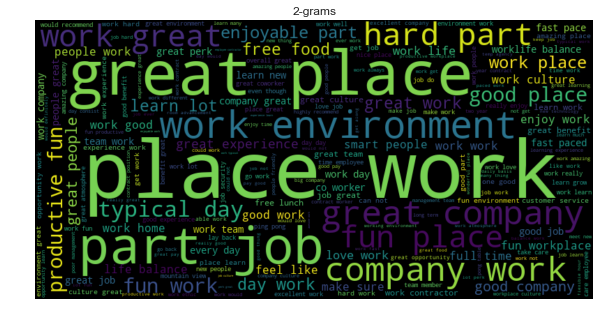

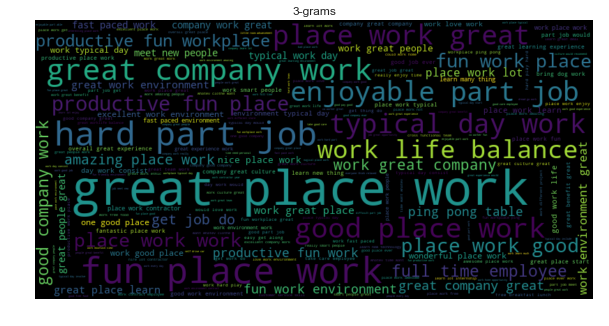

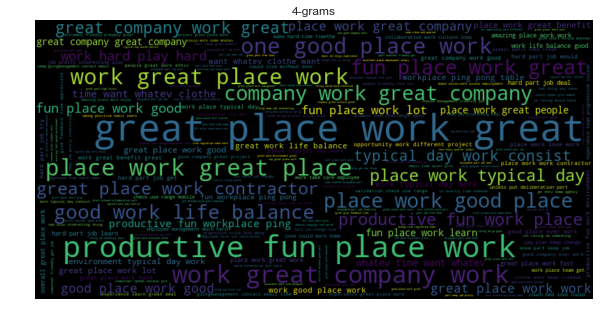

In [57]:
# Week 3 Text Analytics
for n in [2, 3, 4]:
    f = wc.generate_from_frequencies(frequencies={w: i for w, i in zip(ngrams_google[n], ngram_counts_google[n])})
    fig = plt.figure(figsize=(10, 10))
    _ = plt.imshow(f, interpolation='bilinear')
    _ = plt.axis("off")  # assign result to a dummy variable so it doesn't show anything
    _ = plt.title(str(n) + '-grams')

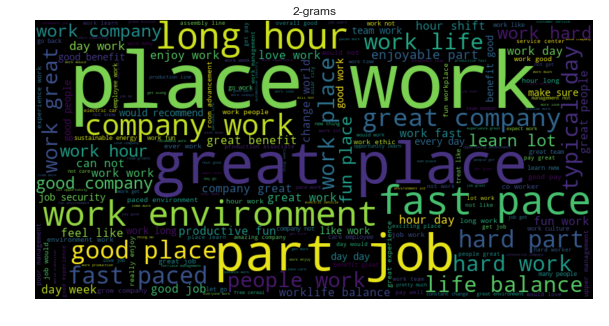

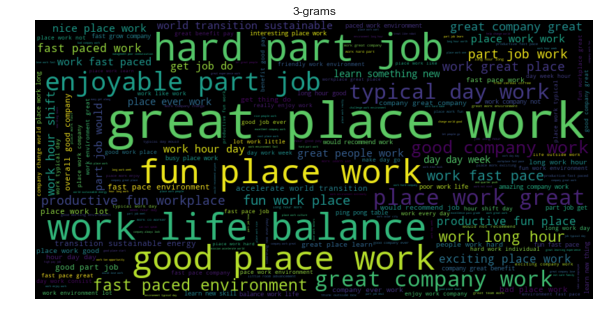

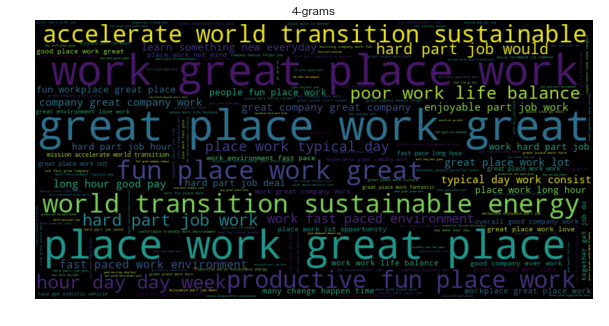

In [59]:
# Week 3 Text Analytics
for n in [2, 3, 4]:
    f = wc.generate_from_frequencies(frequencies={w: i for w, i in zip(ngrams_tesla[n], ngram_counts_tesla[n])})
    fig = plt.figure(figsize=(10, 10))
    _ = plt.imshow(f, interpolation='bilinear')
    _ = plt.axis("off")  # assign result to a dummy variable so it doesn't show anything
    _ = plt.title(str(n) + '-grams')

## Time Series

In [60]:
# Code Source
# https://stackoverflow.com/questions/22391433/
# count-the-frequency-that-a-value-occurs-in-a-dataframe-column

# Value counts by date
df_date_count_google = df_google['date'].value_counts()
df_date_count_tesla = df_tesla['date'].value_counts()


In [61]:
# Save as a dataframe
df_date_google = pd.DataFrame(df_date_count_google)
df_date_tesla = pd.DataFrame(df_date_count_tesla)

In [62]:
df_date_google.head()

,date
2018-06-27,6
2017-08-31,6
2018-01-18,6
2018-01-25,5
2018-10-22,5


In [63]:
# Code Source
# https://stackoverflow.com/questions/26097916/
# convert-pandas-series-to-dataframe

# reset and name index, rename columns
df_count_google = df_date_google.date.to_frame().reset_index()
df_count_google = df_count_google.rename(columns= {'index': 'date', 'date': 'count' })
df_count_google.index.name = 'index'

df_count_tesla = df_date_tesla.date.to_frame().reset_index()
df_count_tesla = df_count_tesla.rename(columns= {'index': 'date', 'date': 'count' })
df_count_tesla.index.name = 'index'


In [64]:
df_count_google.head(2)

,date,count
index,,
0,2018-06-27,6
1,2017-08-31,6


In [65]:
# Code Source - # https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Set date as the index for time series plots
df_count_google.set_index('date', inplace=True)
df_count_tesla.set_index('date', inplace=True)

In [66]:
df_count_google.head(2)

,count
date,
2018-06-27,6
2017-08-31,6


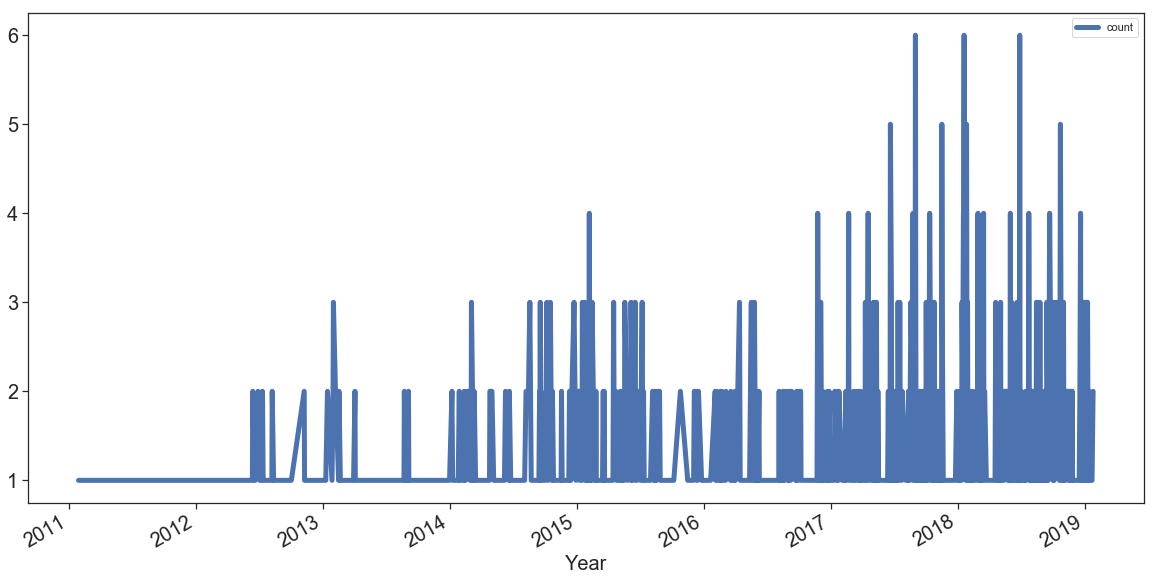

In [67]:
# Code Source - 
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Plot time series google - add labels
df_count_google.plot(figsize=(20,10),linewidth = 5,fontsize=20)
plt.xlabel('Year',fontsize=20);


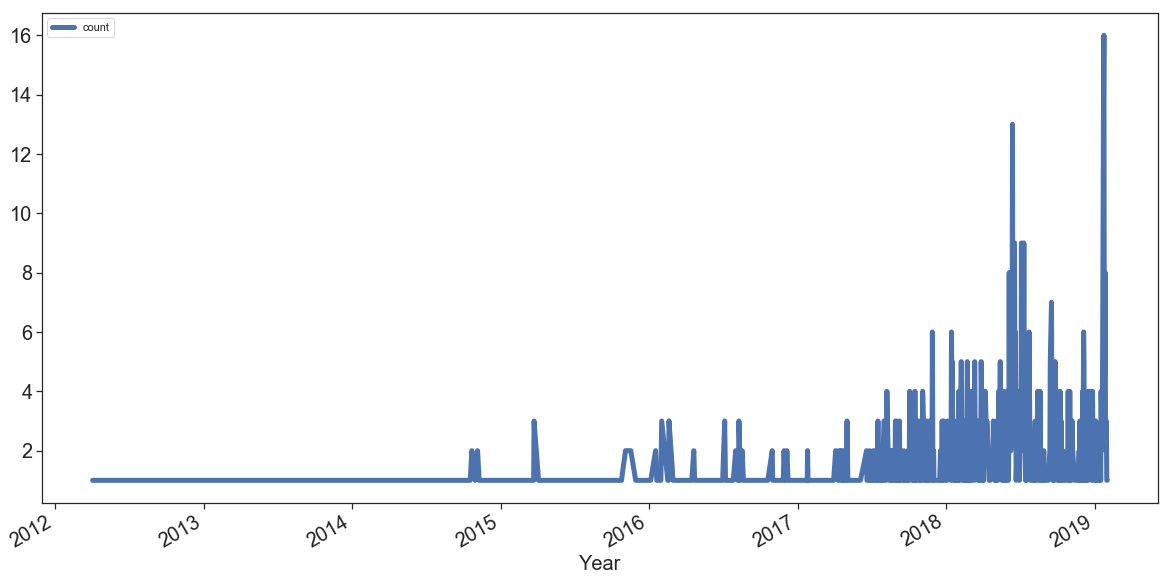

In [68]:
# Plot time series tesla - add labels
df_count_tesla.plot(figsize=(20,10),linewidth = 5,fontsize=20)
plt.xlabel('Year',fontsize=20);

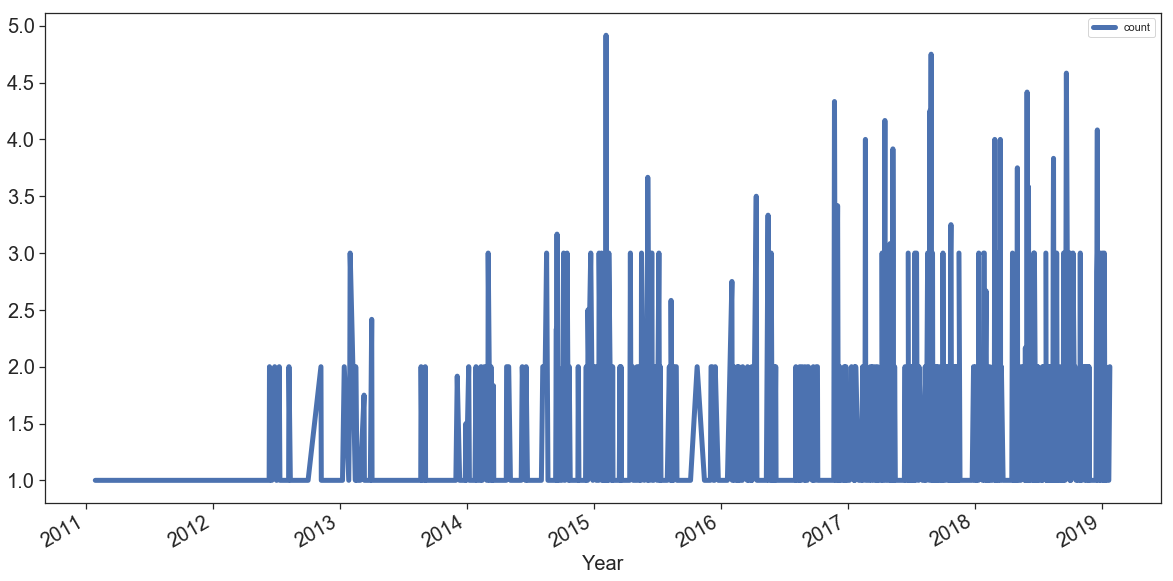

In [69]:
# Code Source - 
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Plot time series rolling mean google - add labels
df_count_google.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

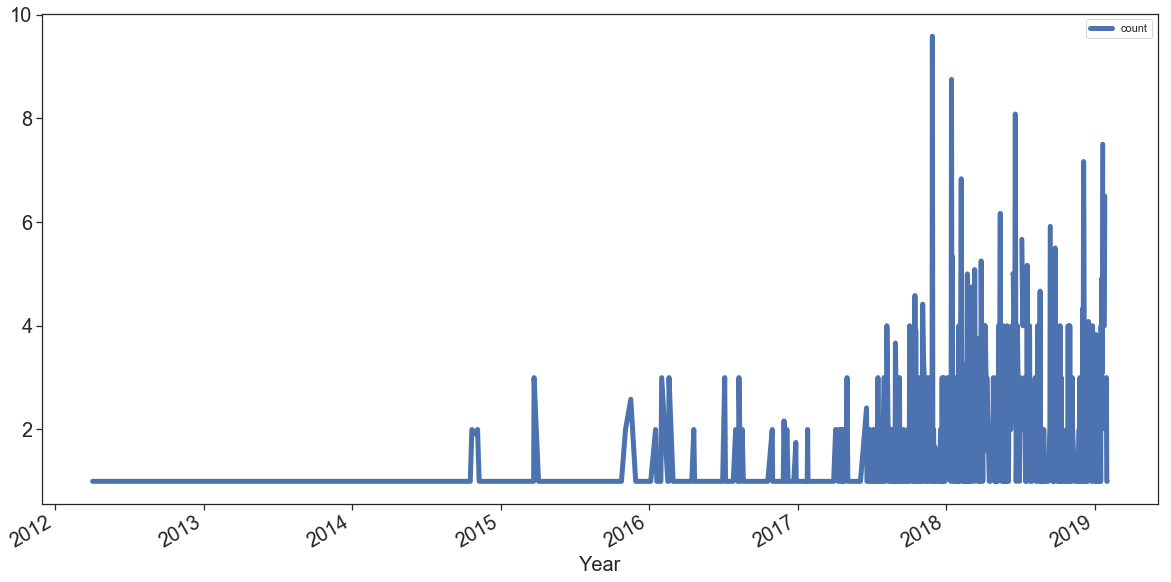

In [70]:
# Plot time series rolling mean tesla - add labels
df_count_tesla.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [71]:
# Code Source
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.dayofweek.html

# Covert to day of the week (Monday=0, Sunday=6)
df_google_day_of_week = df_comp['date'].dt.dayofweek

In [72]:
# Code Source
# https://data-flair.training/blogs/python-switch-case/

# Case statement to match integer to day of week text

def week(i):
    switcher={
        0:'Monday',
        1:'Tuesday',
        2:'Wednesday',
        3:'Thursday',
        4:'Friday',
        5:'Saturday',
        6:'Sunday'
             }
    return switcher.get(i,"Invalid day of week")

In [73]:
# Call function - add new variable to df_comp
df_comp['dayofweek'] = np.array([week(i) for i in df_google_day_of_week[0:]])

In [74]:
# Change data type for categorical variables
df_comp['dayofweek'] = df_comp['dayofweek'].astype('category')

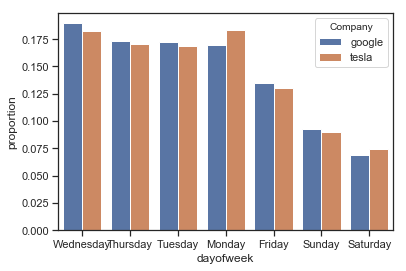

In [75]:
# Code Source
# https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot

x, y, hue = "dayofweek", "proportion", "Company"

(df_comp[x]
 .groupby(df_comp[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data",), x=x, y=y, hue=hue,));

# To do - x labels vertical, weekday order, remove x and y labels

## Sentiment Analysis

In [76]:
# https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
df_google_cln_rev = pd.DataFrame(data=cln_review_google, columns=['Reviews'])
df_tesla_cln_rev = pd.DataFrame(data=cln_review_tesla, columns=['Reviews'])

In [77]:
# https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-

def analize_sentiment(Reviews):
   
    analysis = TextBlob(Reviews)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [78]:
# https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
df_google['SA'] = np.array([analize_sentiment(Reviews) for Reviews in df_google_cln_rev['Reviews']])
df_tesla['SA'] = np.array([analize_sentiment(Reviews) for Reviews in df_tesla_cln_rev['Reviews']])

In [79]:
def analize_polarity(Reviews):
   
    analysis = TextBlob(Reviews)
    return analysis.sentiment.polarity

In [80]:
# https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
df_google['Polarity'] = np.array([analize_polarity(Reviews) for Reviews in df_google_cln_rev['Reviews']])
df_tesla['Polarity'] = np.array([analize_polarity(Reviews) for Reviews in df_tesla_cln_rev['Reviews']])

In [81]:
df_google.head(2)

,title,date,rating,reviews,job_title,emp_status,state,latitude,longitude,Company,SA,Polarity
0,Awesome,2018-01-17,5,Awesome stuff at google if I had to rate it fr...,Camp Counselor,former,MA,42.407211,-71.382437,google,1,0.655952
1,Google is great Bon Apeptit isn’t so great!,2018-08-24,5,Google is a great company and the googler were...,Micro kitchen attendant,former,CA,36.778261,-119.417932,google,1,0.103030


In [82]:
df_tesla.head(2)

,title,date,rating,reviews,job_title,emp_status,state,latitude,longitude,Company,SA,Polarity
0,Stressful,2018-06-14,3,Very tight Schedule.Get to learn a little.Aver...,PV Design Engineer II,current,MA,42.407211,-71.382437,tesla,1,0.009921
1,Looks good on the resume,2019-01-16,3,Tesla asks if you're okay with overtime but yo...,Service Advisor,former,CA,36.778261,-119.417932,tesla,1,0.140000


In [83]:
# Code Source
# https://pbpython.com/pandas-crosstab.html

pd.crosstab(df_google.rating, df_google.SA)

SA,-1,0,1
rating,,,
1,14,3,18
2,8,2,40
3,17,6,165
4,22,8,338
5,11,12,665


In [84]:
pd.crosstab(df_tesla.rating, df_tesla.SA)

SA,-1,0,1
rating,,,
1,56,4,56
2,36,7,90
3,39,7,225
4,18,4,317
5,15,5,356


In [85]:
# https://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas

df_tesla[['reviews','Polarity']].loc[(df_tesla['rating'] == 1) & (df_tesla['SA'] == 1)].head(5)

,reviews,Polarity
16,Tesla is a very fast paced job were what you d...,0.070986
111,"Right so, I've been working here just over a y...",0.113189
141,The culture of working with this company is th...,0.175000
155,Tesla was a dog eat dog place with very little...,0.203125
160,Every day is pretty much the same. you come in...,0.225000


## Geo

In [92]:
# Geo - https://www.datacamp.com/community/tutorials/geospatial-data-python
# Avg sentiment/rating by location - map as a visual - folium - interactive

In [107]:
# Code Source
# https://towardsdatascience.com/pandas-tips-and-tricks-33bcc8a40bb9
df_google_state_SA = df_google.groupby('state')['SA'].sum()
df_tesla_state_SA = df_tesla.groupby('state')['SA'].sum()

In [108]:
df_google_state_SA = pd.DataFrame(df_google_state_SA)
df_tesla_state_SA = pd.DataFrame(df_tesla_state_SA)

In [109]:
df_google_state_SA.reset_index(inplace=True)
df_tesla_state_SA.reset_index(inplace=True)

In [112]:
# https://stackoverflow.com/questions/34397982/pandas-dataframe-access-multiple-items-with-not-equal-to
notERR_google = df_google_state_SA[df_google_state_SA['state'] != 'ERR']
notERR_tesla = df_tesla_state_SA[df_tesla_state_SA['state'] != 'ERR']

In [105]:
# https://medium.com/@austinlasseter/using-folium-to-generate-a-simple-map-of-your-pandas-data-87ddc5d55f8d
# https://python-graph-gallery.com/292-choropleth-map-with-folium/

# Code Source
# https://github.com/bradtraversy/python_folium_example/edit/master/data/us-states.json

map = folium.Map(location=[48, -102], zoom_start=3)

state_geo = os.path.join('/Users/christiandavies/Desktop/data_pract_1/Project/', 'us-states.json')

map.choropleth(geo_data=state_geo, data=notERR,
             columns=['state', 'SA'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Sentiment')


/Users/christiandavies/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [106]:
map

In [114]:
# https://medium.com/@austinlasseter/using-folium-to-generate-a-simple-map-of-your-pandas-data-87ddc5d55f8d
# https://python-graph-gallery.com/292-choropleth-map-with-folium/

map = folium.Map(location=[48, -102], zoom_start=3)

map.choropleth(geo_data=state_geo, data=notERR_tesla,
             columns=['state', 'SA'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Sentiment')

map


/Users/christiandavies/anaconda3/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Kmeans - clustering

In [116]:
# Code Source
# http://brandonrose.org/clustering 

# Cosine Similarity Distance measurement - doc compared to all other docs

dist_google = 1 - cosine_similarity(train_tfidf_vectors_google)
dist_tesla = 1 - cosine_similarity(train_tfidf_vectors_tesla)

#### Should I combine other variables?? - watch datacamp on unsupervised for tips

In [117]:
# Code Source
# # https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

# Elbow to identify optimal # of clusters

def elbow(file):
    Sum_of_squared_distances = []
    K = range(1,150)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(train_tfidf_vectors_google)
        Sum_of_squared_distances.append(km.inertia_)
    
    
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()


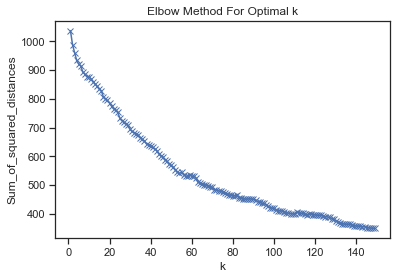

In [118]:
elbow(dist_google)

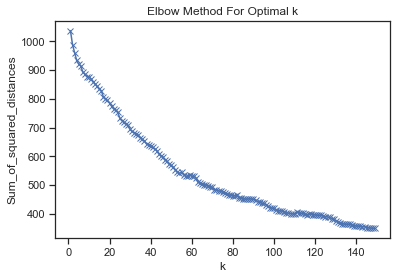

In [119]:
elbow(dist_tesla)

In [120]:
# Code Source
# https://pythonprogramminglanguage.com/kmeans-text-clustering/

true_k_google = 15
model_google = KMeans(n_clusters=true_k_google, init='k-means++', max_iter=100, n_init=1)
model_google.fit(train_tfidf_vectors_google)

true_k_tesla = 15
model_tesla = KMeans(n_clusters=true_k_tesla, init='k-means++', max_iter=100, n_init=1)
model_tesla.fit(train_tfidf_vectors_tesla)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=15, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [121]:
# Code Source
# https://pythonprogramminglanguage.com/kmeans-text-clustering/

# Google

print("Top terms per Google cluster:")
order_centroids_google = model_google.cluster_centers_.argsort()[:, ::-1]
terms_google = tfidf_vectorizer_google.get_feature_names()
for i in range(true_k_google):
    print("Cluster %d:" % i),
    for ind in order_centroids_google[i, :10]:
        print(' %s' % terms_google[ind]),
    print

Top terms per Google cluster:
Cluster 0:
 work place
 good place
 fun work
 place work
 work good
 productive fun
 work environment
 one good
 good work
 work work
Cluster 1:
 great perk
 feel like
 great place
 free food
 place work
 learn lot
 free lunch
 work great
 fun work
 fast paced
Cluster 2:
 company work
 great company
 good company
 work great
 work culture
 great place
 fun workplace
 work environment
 place work
 productive fun
Cluster 3:
 part job
 hard part
 enjoyable part
 typical day
 day work
 work environment
 work team
 work day
 co worker
 learn work
Cluster 4:
 work life
 life balance
 great place
 good work
 place work
 great work
 fun work
 company work
 company great
 excellent work
Cluster 5:
 great job
 job great
 overall great
 culture great
 work home
 free lunch
 care employee
 part job
 work team
 learn lot
Cluster 6:
 place work
 great place
 fun place
 work great
 great people
 learn lot
 work hard
 nice place
 free lunch
 full time
Cluster 7:
 work con

In [122]:
# Code Source
# https://pythonprogramminglanguage.com/kmeans-text-clustering/

# Tesla

print("Top terms per Tesla cluster:")
order_centroids_tesla = model_tesla.cluster_centers_.argsort()[:, ::-1]
terms_tesla = tfidf_vectorizer_tesla.get_feature_names()
for i in range(true_k_tesla):
    print("Cluster %d:" % i),
    for ind in order_centroids_tesla[i, :10]:
        print(' %s' % terms_tesla[ind]),
    print

Top terms per Tesla cluster:
Cluster 0:
 typical day
 day work
 long hour
 make sure
 day week
 place work
 work day
 hard part
 fast paced
 can not
Cluster 1:
 place work
 great place
 good place
 fun place
 people work
 work work
 work good
 great company
 work company
 room advancement
Cluster 2:
 fast pace
 work fast
 good company
 great experience
 company work
 love work
 good work
 hard work
 long hour
 place work
Cluster 3:
 work great
 place work
 great place
 fun place
 company work
 love work
 great company
 hard work
 good place
 great work
Cluster 4:
 like work
 company not
 work company
 work like
 good company
 ever work
 let go
 company work
 enjoy work
 can not
Cluster 5:
 many people
 people work
 great company
 care employee
 fast paced
 fast pace
 work life
 worklife balance
 upper management
 go back
Cluster 6:
 work environment
 fast pace
 team work
 environment work
 company work
 great company
 fun work
 great work
 life balance
 work life
Cluster 7:
 every day


In [124]:
# Code Soruce
# https://pythonprogramminglanguage.com/kmeans-text-clustering/

Y = tfidf_vectorizer_google.transform(["hard place to work hate food."])
prediction = model_google.predict(Y)
print(prediction)

[9]


In [125]:
# df_google['cluster'] = clusters
df_google['cluster'] = model_google.labels_
df_tesla['cluster'] = model_tesla.labels_

In [126]:
# http://brandonrose.org/clustering
df_google['cluster'].value_counts() #number of reviews per cluster

9     680
6     155
3      96
0      91
2      55
11     38
14     34
8      34
4      30
12     28
1      22
13     19
5      19
7      16
10     12
Name: cluster, dtype: int64

In [127]:
# http://brandonrose.org/clustering
df_tesla['cluster'].value_counts() #number of reviews per cluster

9     589
1     144
13     64
10     64
2      54
6      52
12     48
11     34
3      33
0      33
4      31
8      29
7      23
14     22
5      15
Name: cluster, dtype: int64

In [128]:
# http://brandonrose.org/clustering
grouped_google = df_google['rating'].groupby(df_google['cluster']) #groupby cluster for aggregation purposes

grouped_google.mean() #average rank (1 to 100) per cluster

cluster
0     4.285714
1     4.000000
2     4.709091
3     4.135417
4     4.233333
5     4.578947
6     4.477419
7     3.937500
8     4.147059
9     4.069118
10    4.500000
11    4.473684
12    4.464286
13    4.789474
14    4.647059
Name: rating, dtype: float64

In [129]:
# http://brandonrose.org/clustering
grouped_tesla = df_tesla['rating'].groupby(df_tesla['cluster']) #groupby cluster for aggregation purposes

grouped_tesla.mean() #average rank (1 to 100) per cluster

cluster
0     3.606061
1     3.972222
2     3.888889
3     4.454545
4     3.451613
5     3.200000
6     3.692308
7     3.956522
8     3.344828
9     3.370119
10    3.796875
11    4.088235
12    3.166667
13    3.953125
14    3.454545
Name: rating, dtype: float64

## LSA/NMF

In [130]:
# Code Source
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_
# nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [131]:
# Fit the NMF model 1 

n_components = 10
n_top_words = 10

nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(train_tfidf_vectors_google)

tfidf_feature_names = tfidf_vectorizer_google.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: great place place work work great place learn great people smart people life balance place great great perk great work
Topic #1: part job hard part enjoyable part co worker work day learn work fast pace new people day day work team
Topic #2: company work great company good company work great company great people great great work work culture worklife balance work life
Topic #3: work environment environment great great work good work excellent work love work fast paced fun work environment work great coworker
Topic #4: fun place productive fun fun workplace work lot place work good job ping pong work good work people place learn
Topic #5: work place fun work productive fun place great day day life balance fast paced work life work good can not
Topic #6: typical day day work enjoyable part make sure every day learn new hard part good part enjoy work go work
Topic #7: place work good place work great amazing place work work free food work good work hard one good nice place
Topic

In [132]:
# Fit the NMF model 2 
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(train_tfidf_vectors_google)

tfidf_feature_names = tfidf_vectorizer_google.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: place work great place smart people great environment worklife balance work lot place learn work hard great benefit free food
Topic #1: part job hard part enjoyable part work day fast pace work team co worker get work typical day customer service
Topic #2: company work great company company great good company worklife balance work company work really great environment care employee work great
Topic #3: work environment good work environment great work fun great coworker excellent work environment work great work fast paced great team
Topic #4: place work fun place free lunch productive fun work good work people work lot nice place amazing place work learn
Topic #5: fun work work culture people work great work work home work place team work opportunity work fun environment place great
Topic #6: typical day day work work place fun workplace productive fun make sure can not even though ping pong mountain view
Topic #7: good place work work love work full time job great work cont

In [133]:
# Fit the LDA model 1 
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(train_tfidf_vectors_google)

tf_feature_names = tfidf_vectorizer_google.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: work home work culture worklife balance customer service can not get work great work care employee company work work good
Topic #1: make sure feel like fast pace team work part job fun place learn work great team work team place learn
Topic #2: company work great company great perk good company free lunch work company work great great benefit people great would recommend
Topic #3: great experience good job work really experience work people work overall great environment work every day work company work great
Topic #4: productive fun fun place fun work place work fun workplace ping pong great people good experience work place work fun
Topic #5: great place place work good place work great work life life balance job great great job learn new work lot
Topic #6: work work love work work hard learn lot amazing place co worker place work every day good benefit enjoy work
Topic #7: good company smart people full time work place fun environment opportunity work nice place time emplo

In [134]:
# Fit the NMF model 1 

n_components = 10
n_top_words = 10

nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(train_tfidf_vectors_tesla)

tfidf_feature_names = tfidf_vectorizer_tesla.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: place work good place fun place work great people work work good productive fun work work every day work day
Topic #1: fast pace company work great company good company work fast company great love work great experience work company work hour
Topic #2: part job hard part enjoyable part typical day day work job work work hard job would hour day team work
Topic #3: work environment environment work great work team work fun work change world enjoy work work culture work people productive fun
Topic #4: great place work great place work people work great company room advancement company great grow company team work work hard
Topic #5: work life life balance work company great people work work worklife balance great work people work long work job security
Topic #6: hard work change world work hard work ethic work great work not work work treat like feel like sustainable energy
Topic #7: long hour work long hour long good pay work hour can not hour work good people hour day care emp

In [135]:
# Fit the NMF model 2 
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(train_tfidf_vectors_tesla)

tfidf_feature_names = tfidf_vectorizer_tesla.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: place work great place work great good place fun place people work work not great team work work work fun
Topic #1: work hour hour day love work day week work day great work great experience would not great job work work
Topic #2: part job hard part typical day day work enjoyable part job work make sure job would work hard hour day
Topic #3: work environment great place team work work culture room advancement co worker fun workplace environment work change world learn new
Topic #4: great company work hard company great poor management company work great benefit grow company job security go back benefit great
Topic #5: work company worklife balance productive fun enjoy work great people like work sustainable energy really enjoy company not let go
Topic #6: fast pace work life life balance day day good work employee work work fast room advancement work ethic great people
Topic #7: long hour can not work long good people hour long hour work experience work care employee work eth

In [136]:
# Fit the LDA model 1 
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(train_tfidf_vectors_tesla)

tf_feature_names = tfidf_vectorizer_tesla.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: fast pace fast paced work fast room advancement paced environment great experience hour shift work team long hour love work
Topic #1: great company worklife balance company great great benefit people work learn new company work would love great team work hard
Topic #2: enjoy work work place treat like not work company not great people go back really enjoy hour work learn lot
Topic #3: hard work learn lot day work typical day work not amazing company long hour work hard work ethic change world
Topic #4: good place day day experience work place work great job work hour day week hour day team work good work
Topic #5: would recommend benefit good fun workplace productive fun good pay good people long hour hard work feel like employee work
Topic #6: place work great place good job work great day week grow company hour day sustainable energy work work job security
Topic #7: part job company work hard part enjoyable part good company work company typical day every day care employee 

In [ ]:
# LSA or LDA easier in R - save tfidf in python - load into R and run LDA and LSA.
# Graphlab - nice library for topic models, try first in python - activate license

 ### parameter tuning LDA NMF ABOVE

In [ ]:
# Code Source
# DataCamp course supervised learning with SciKit Learn

# df_google_emp_status = pd.get_dummies(df_google['emp_status'])

In [ ]:
# df_google_sup = df_google_emp_status["current"] + df_google['rating']
# google_review_text = df_google["title"] + ' ' + df_google["reviews"]

In [ ]:
# df_google_trimmed = pd.DataFrame([df_google.location,df_google.rating]).transpose()

In [ ]:
# https://stackoverflow.com/questions/36967666/transform-scipy-sparse-csr-to-pandas

# df_tfidf = pd.DataFrame(train_tfidf_vectors_google.toarray())

In [ ]:
# df_google_sl = pd.concat([df_google_emp_status, df_google_trimmed,df_tfidf], axis=1, ignore_index=True) 
# df_google_sl_renamed = df_google_sl.rename(columns= {0: 'current', 1: 'former', 2: 'location', 3: 'rating' })


In [ ]:
# Should I use something like PCA for feature reduction?
# Better to do sentiment analysis and predict sentiment (binary classification) or multiclass and predict rating?

# Topic Modeling - lda, lsa - useful - take action
# Words - make pick up some words that are not in sentiment - extract the most popular words

# densify tfidf vector - take top 100 words - use min freq to get certain number of dimensions - max features 
# - tfidf documentation

# way to look at most important words - look this up - forest methods.  random forest - feature importance